In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import datetime as dt
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

In [39]:
# define parameters
batch_size = 32
minimum_len = 128
epochs = 200
val_period = 20 # 몇 epoch에 한번씩 validation?

### Getting file names

In [23]:
#currdir= os.getcwd()
rootdir = '/home/taejoon/PhysioNetChallenge'
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Mel_data_20200402_128' 
mel_directory = os.path.join(rootdir, mel_name)
results_directory = os.path.join(rootdir, 'results')
#save_directory = os.path.join(currdir, '')
if not os.path.isdir(input_directory):
        os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
        os.mkdir(mel_directory)
if not os.path.isdir(results_directory):
        os.mkdir(results_directory)                       

In [5]:
# Find files
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)

In [6]:
input_file_names = sorted(input_files)
input_file_names

['A0001.mat',
 'A0002.mat',
 'A0003.mat',
 'A0004.mat',
 'A0005.mat',
 'A0006.mat',
 'A0007.mat',
 'A0008.mat',
 'A0009.mat',
 'A0010.mat',
 'A0011.mat',
 'A0012.mat',
 'A0013.mat',
 'A0014.mat',
 'A0015.mat',
 'A0016.mat',
 'A0017.mat',
 'A0018.mat',
 'A0019.mat',
 'A0020.mat',
 'A0021.mat',
 'A0022.mat',
 'A0023.mat',
 'A0024.mat',
 'A0025.mat',
 'A0026.mat',
 'A0027.mat',
 'A0028.mat',
 'A0029.mat',
 'A0030.mat',
 'A0031.mat',
 'A0032.mat',
 'A0033.mat',
 'A0034.mat',
 'A0035.mat',
 'A0036.mat',
 'A0037.mat',
 'A0038.mat',
 'A0039.mat',
 'A0040.mat',
 'A0041.mat',
 'A0042.mat',
 'A0043.mat',
 'A0044.mat',
 'A0045.mat',
 'A0046.mat',
 'A0047.mat',
 'A0048.mat',
 'A0049.mat',
 'A0050.mat',
 'A0051.mat',
 'A0052.mat',
 'A0053.mat',
 'A0054.mat',
 'A0055.mat',
 'A0056.mat',
 'A0057.mat',
 'A0058.mat',
 'A0059.mat',
 'A0060.mat',
 'A0061.mat',
 'A0062.mat',
 'A0063.mat',
 'A0064.mat',
 'A0065.mat',
 'A0066.mat',
 'A0067.mat',
 'A0068.mat',
 'A0069.mat',
 'A0070.mat',
 'A0071.mat',
 'A007

### Shuffle and divide files into train/eval/test

In [7]:
data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True)
data_train, data_val = train_test_split(data, test_size = 0.25, train_size = 0.75, shuffle=True)

In [8]:
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

(4125,) (1376,) (1376,)


### Preprocess labels (one-hot encoding)

In [9]:
# Find unique number of classes  
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())

    return sorted(unique_classes)

unique_classes = get_unique_classes(input_directory, input_files)
# Creating one-hot vector for Y
# num = np.unique(classes, axis=0)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
#class2index

def one_hot_encoding(one_hot_vector,y, class2index):

       ind=class2index[y]
       one_hot_vector[ind]=1
       return one_hot_vector


In [10]:
class2index

{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}

In [ ]:
# # Checkinc which x is minimum
# minimum = 300
# for file in input_file_names:
#     tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
#     print(np.shape(tmp_file))
#     if len(tmp_file) < minimum:
#         minimum = tmp_file.shape[0]
# #print(minimum)

In [ ]:
# classes= np.asarray(classes)    

In [ ]:
# mel_files = np.asarray(mel_files)

In [ ]:

# dataset = dataset.batch(batch_size)
# dataset

In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# x, x_test, y, y_test  = train_test_split(mel_files, classes, test_size=0.2, train_size = 0.8)
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25, train_size = 0.75)

In [ ]:
# print(np.shape(x_train), np.shape(x_val), np.shape(x_test), np.shape(y_train), np.shape(y_val), np.shape(y_test))

### CNN Model

In [11]:
from keras.applications.densenet import DenseNet169
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model 

input_tensor = Input(shape=(128, 128, 12))
base_model = DenseNet169(input_tensor=input_tensor, weights=None, include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
pred = Dense(9, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=pred)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 12) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 12) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   37632       zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(minimum_len, minimum_len, 12)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(9, activation='softmax'))

In [13]:
def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)    
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

In [ ]:
def exploratory_look(input_directory,file, class2index):
    
    classes = []

    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp            

for file in input_file_names:
    tmp = exploratory_look(input_directory, file, class2index)

In [ ]:
# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

In [ ]:
sub, cls, num = get_labels2(input_directory, class2index, input_file_names)
print(len(num)) # number of subjects who have more than two diagnoses
print(num.count(2)) # number of subjects who have two diagnoses
print(num.count(3)) # number of subjects who have three diagnoses

In [14]:
# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

In [15]:
classes2=[]
for file in input_file_names:
    classes = get_labels(input_directory, file, class2index)
    classes2.append(classes)
classes2[42] # 43th subject has multi-diagnoses

[1, 0, 0, 0, 0, 0, 1, 0, 0]

In [17]:
def randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len): # step = 0, 1, 2, 3....
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data_train[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        mel_files.append(clip_file)
        
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    return mel_files, classes

In [18]:
def randextract_mels_val(curr_range_start, curr_range_end, data_val, mel_directory, class2index, minimum_len): # step = 0, 1, 2, 3....
    mel_files = []
    classes = []
    curr_file_indices = data_val[int(curr_range_start):int(curr_range_end)]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        mel_files.append(clip_file)
        
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    return mel_files, classes

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
def train(data_train, mel_directory, batch_size, class2index, minimum_len): 
    
    loss=[]
    acc = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps):
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        train_loss_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss.append(train_loss_tmp[0])
        acc.append(train_loss_tmp[1])

    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    return loss, acc

In [ ]:
def voting(data, epochs, minimum_len,flag='val', ct=None): # valid에서 이 함수 부를 떄는 ct 인자로 넣어주기
    # 1. 파일 읽어오기
    #2. 128씩 쪼개기 (끄트머리 버리기-> np.floor)
    #3. model.predict -> logit 가져오기 (thresholding)
    #4. 최다 득표 return (최다 득표와 실제 label 비교)
    if flag=='val':
        per_epoch = epochs/20 # how many validation sets we need: divide total epochs (1000) by 20
        per_val = np.floor(len(data)/per_epoch)
        curr_range_start = (ct-1)*per_val
        curr_range_end = ct*per_val
    elif flag=='test':
        curr_range_start = 0
        curr_range_end = len(data)
    curr_file_indices = data[curr_range_start:curr_range_end]
    
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = np.floor(tmp_file.shape[1]/minimum_len)
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = blocks*minimum_len
            end = (blocks+1)*minimum_len - 1
            curr_block = tmp_file(start:end)
            logit = model.predict(curr_block)
            

In [ ]:
file = data_test[1]
tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
block=0
curr_block = tmp_file[0:128]
np.shape(curr_block)
curr_block = np.expand_dims(curr_block,0)
# np.shape(curr_block)
logit = model.predict(curr_block)
logit

In [ ]:
ans=get_labels(input_directory, file.replace('.mat', '.hea'), class2index)
ans

In [21]:
def validation(ct, data_val, mel_directory, class2index, minimum_len, epochs): 
    loss = []
    acc = []
    
    per_epoch = epochs/20 # how many validation sets we need: divide total epochs by 20
    per_val = np.floor(len(data_val)/per_epoch)
    curr_range_start = (ct-1)*per_val
    curr_range_end = ct*per_val
    batch_mels, batch_labels = randextract_mels_val(curr_range_start, curr_range_end, data_val, mel_directory, class2index, minimum_len)
    batch_mels = np.asarray(batch_mels)
    batch_labels = np.asarray(np.squeeze(batch_labels))
    val_loss_tmp = model.test_on_batch(batch_mels, batch_labels)
    loss.append(val_loss_tmp[0])
    acc.append(val_loss_tmp[1])
    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    return loss, acc

In [22]:
ct = 0
val_loss_sum = []
val_acc_sum=[]
train_loss_sum=[]
train_acc_sum=[]
save_name = os.path.join(results_directory, 'MEL.h5') 
for num_epoch in range(epochs):
    if (num_epoch+1)%val_period == 0: # Validation for every 20 epochs
        ct += 1
        val_loss, val_acc = validation(ct,data_val, mel_directory, class2index, minimum_len, epochs)
        print('\nValidation', int((num_epoch+1)/20),'valid_loss:',f'{val_loss:.3f}', 'valid_acc:',f'{val_acc:.3f}',"\t", dt.datetime.now())
        val_loss_sum.append(val_loss)
        val_acc_sum.append(val_acc)
    else: 
        train_loss, train_acc = train(data_train, mel_directory, batch_size, class2index, minimum_len)
        print('\nEpoch',num_epoch+1,'train_loss:',f'{train_loss:.3f}','train_acc:',f'{train_acc:.3f}',"\t", dt.datetime.now())
        train_loss_sum.append(train_loss)
        train_acc_sum.append(train_acc)
   
    model.save(save_name)
#    model.save('MEL.h5')  
#     save_name = output_directory + '/' + input_files[i].replace('.mat', '.npy') #filename.replace('.mat', '.npy')


Epoch 1 train_loss: 0.318 train_acc: 0.884 	 2020-04-07 05:27:34.298034

Epoch 2 train_loss: 0.258 train_acc: 0.906 	 2020-04-07 05:29:19.679848

Epoch 3 train_loss: 0.232 train_acc: 0.915 	 2020-04-07 05:29:40.668645

Epoch 4 train_loss: 0.218 train_acc: 0.920 	 2020-04-07 05:30:01.654437

Epoch 5 train_loss: 0.212 train_acc: 0.922 	 2020-04-07 05:30:22.671964

Epoch 6 train_loss: 0.198 train_acc: 0.926 	 2020-04-07 05:30:43.734834

Epoch 7 train_loss: 0.186 train_acc: 0.931 	 2020-04-07 05:31:04.813313

Epoch 8 train_loss: 0.179 train_acc: 0.932 	 2020-04-07 05:31:25.876970

Epoch 9 train_loss: 0.172 train_acc: 0.936 	 2020-04-07 05:31:46.960671

Epoch 10 train_loss: 0.165 train_acc: 0.938 	 2020-04-07 05:32:08.077234

Epoch 11 train_loss: 0.156 train_acc: 0.942 	 2020-04-07 05:32:29.141042

Epoch 12 train_loss: 0.153 train_acc: 0.943 	 2020-04-07 05:32:50.226549

Epoch 13 train_loss: 0.149 train_acc: 0.945 	 2020-04-07 05:33:11.332319

Epoch 14 train_loss: 0.144 train_acc: 0.945 	 


Epoch 112 train_loss: 0.017 train_acc: 0.995 	 2020-04-07 06:06:22.156086

Epoch 113 train_loss: 0.017 train_acc: 0.994 	 2020-04-07 06:06:43.226129

Epoch 114 train_loss: 0.018 train_acc: 0.994 	 2020-04-07 06:07:04.357867

Epoch 115 train_loss: 0.016 train_acc: 0.994 	 2020-04-07 06:07:25.447972

Epoch 116 train_loss: 0.017 train_acc: 0.994 	 2020-04-07 06:07:46.567486

Epoch 117 train_loss: 0.020 train_acc: 0.993 	 2020-04-07 06:08:07.642720

Epoch 118 train_loss: 0.015 train_acc: 0.995 	 2020-04-07 06:08:28.724114

Epoch 119 train_loss: 0.016 train_acc: 0.995 	 2020-04-07 06:08:49.794143

Validation 6 valid_loss: 1.050 valid_acc: 0.875 	 2020-04-07 06:08:51.206145

Epoch 121 train_loss: 0.015 train_acc: 0.995 	 2020-04-07 06:09:12.266997

Epoch 122 train_loss: 0.014 train_acc: 0.995 	 2020-04-07 06:09:33.338591

Epoch 123 train_loss: 0.015 train_acc: 0.995 	 2020-04-07 06:09:54.416872

Epoch 124 train_loss: 0.015 train_acc: 0.995 	 2020-04-07 06:10:15.470977

Epoch 125 train_loss:

Text(0.5, 1.0, 'Validation accuracy and loss')

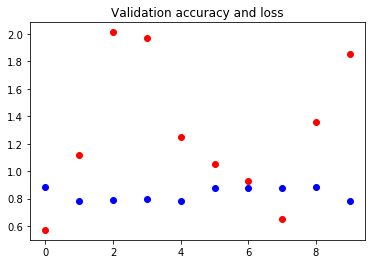

In [50]:
epochs_val=int(epochs/val_period)
plt.plot(range(epochs_val),val_acc_sum, 'bo', label='Validation Acc')
plt.plot(range(epochs_val), val_loss_sum, 'ro', label='Validation Loss')
plt.title('Validation accuracy and loss')

Text(0.5, 1.0, 'Training accuracy and loss')

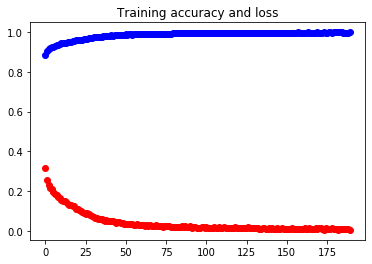

In [48]:
epochs_train = range(epochs - epochs_val)
plt.plot(epochs_train, train_acc_sum, 'bo', label='Training Acc')
plt.plot(epochs_train, train_loss_sum, 'ro', label='Training Loss')
plt.title('Training accuracy and loss')


### Now, test with test data

In [51]:
def test(data_test, mel_directory, class2index, minimum_len): 
    
    metrics = []
    batch_mels, batch_labels = randextract_mels_val(0, len(data_test)-1, data_val, mel_directory, class2index, minimum_len)
    # although rendextract_mels_val, you can use the same function fpr test
    batch_mels = np.asarray(batch_mels)
    batch_labels = np.asarray(np.squeeze(batch_labels))
    test_loss_tmp = model.test_on_batch(batch_mels, batch_labels)
    loss = test_loss_tmp[0]
    acc = test_loss_tmp[1]
#     metrics.append(test_loss_tmp)

#     metrics = np.mean(np.array(metrics))
    return loss, acc

In [52]:
test_metrics = test(data_test, mel_directory, class2index, minimum_len)
print('\nTest result: loss:',f'{test_metrics[0]:.3f}','accuracy:', f'{test_metrics[1]:.3f}',"\t", dt.datetime.now())


Test result: loss: 1.852 accuracy: 0.788 	 2020-04-08 06:01:46.574039


In [ ]:
# history = model.fit(
#       mel_files, classes)

In [ ]:
# from keras import optimizers
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(lr=1e-4),
#               metrics=['acc'])
# nepochs=1000
# model.fit(x_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(x_val, y_val), verbose=2)
# model.save('ECG1.h5')